In [1]:
#import Section
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import re
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
import xgboost as xgb


from sklearn.metrics import log_loss, accuracy_score, auc, roc_auc_score, average_precision_score,precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 1. Reading Data

In [2]:
url='./adult.data'
#columns name according to adult.names
cols=["age","workclass","fnlwgt","education","education-num","marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week","native-country","wage_class"]

train_set=pd.read_csv(url, names=cols)   # reading and setting names
test_set = pd.read_csv('./adult.test',skiprows = 1, header = None, names=cols)   #coz row one is multi index 

#test_set.head()
#train_set.head()
train_set.shape, test_set.shape

((32561, 15), (16281, 15))

## 2. Pre-Processing

In [3]:
#appending both as we know both having same column so we can pre-process them in same frame

#adding extra column to both mark tarin and test seperately
train_set['mark']="train_set"
test_set['mark']="test_set"
df1 = train_set.append(test_set)
df1.shape

(48842, 16)

In [4]:
#checking intigrity after append
#df1.head()
#df1.columns
#df1.mark.value_counts()
#df1.mark.unique()

In [5]:
#check for null
df1.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
wage_class        0
mark              0
dtype: int64

Observation: There is no null values but might be some malicious or unmeaningful data identify that

In [6]:
#first identify the columns types
df1.dtypes 

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
wage_class        object
mark              object
dtype: object

In [57]:
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,48842.0,38.643585,13.710510,17.0,28.0,37.0,48.0,90.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
education-num,48842.0,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0
capital-gain,48842.0,1079.067626,7452.019058,0.0,0.0,0.0,0.0,99999.0
capital-loss,48842.0,87.502314,403.004552,0.0,0.0,0.0,0.0,4356.0
hours-per-week,48842.0,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


In [58]:
df1.describe(include='O')   # object type columns

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,wage_class,mark
count,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,9,16,7,15,6,5,2,42,2,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K,train_set
freq,33906,15784,22379,6172,19716,41762,32650,43832,37155,32561


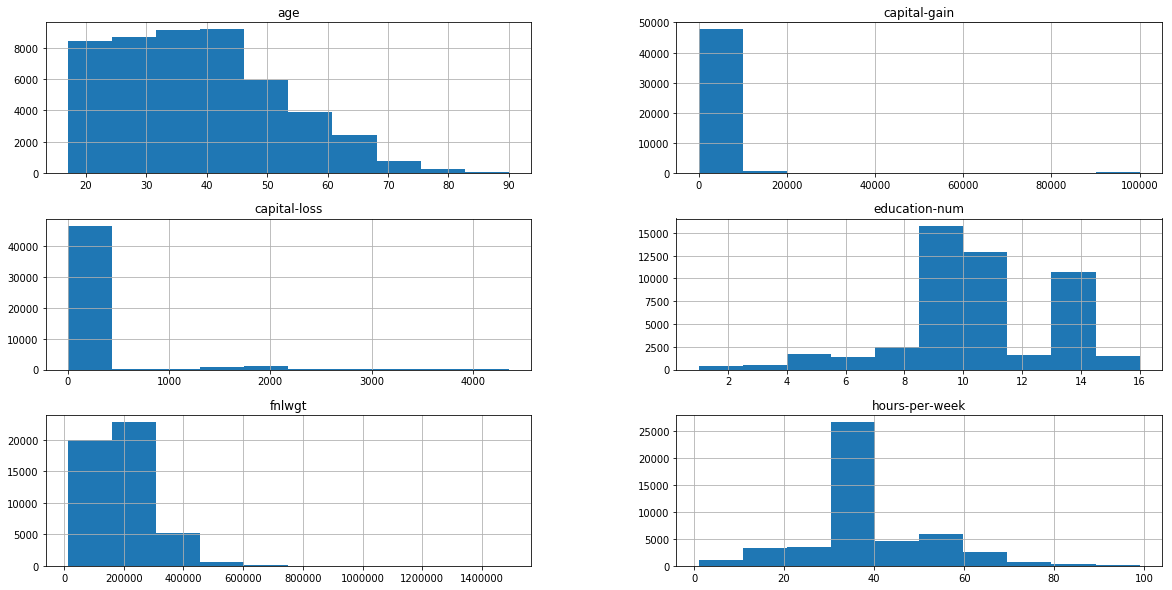

In [60]:
# data Distribution
df1.hist(figsize=(20,10))
plt.show()

In [7]:
#Collect columns type wise in differnt lists
obj_cols = []
num_cols = []
for col_type in df1.columns:
    if df1[col_type].dtype == 'object':
        obj_cols.append(col_type)
    else:
        num_cols.append(col_type)
    
#num_cols,obj_cols


In [8]:
#checking differnt types of unique values in each `object` type columns

for col_item in obj_cols:
    print('_'*10,col_item, '_'*10)
    print(df1[col_item].value_counts())
    print('_'*10,'Uniqe values in', col_item, '_'*10)
    print(df1[col_item].unique())
    print("Total Unique Count:",df1[col_item].value_counts().count())

__________ workclass __________
 Private             33906
 Self-emp-not-inc     3862
 Local-gov            3136
 ?                    2799
 State-gov            1981
 Self-emp-inc         1695
 Federal-gov          1432
 Without-pay            21
 Never-worked           10
Name: workclass, dtype: int64
__________ Uniqe values in workclass __________
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
Total Unique Count: 9
__________ education __________
 HS-grad         15784
 Some-college    10878
 Bachelors        8025
 Masters          2657
 Assoc-voc        2061
 11th             1812
 Assoc-acdm       1601
 10th             1389
 7th-8th           955
 Prof-school       834
 9th               756
 12th              657
 Doctorate         594
 5th-6th           509
 1st-4th           247
 Preschool          83
Name: education, dtype: int64
__________ Uniqe values in education __________
[' Bachelors' ' HS-g

### Observation:
We can now clearly identify the diff. types, their count and defficiency in the features

In [9]:
#clean wage_class first remove '.' make it binary
#use regular expression to remove '.'

df1['wage_class'].unique()

array([' <=50K', ' >50K', ' <=50K.', ' >50K.'], dtype=object)

In [10]:
df1['wage_class'] = [re.sub(r"\.",'', x) for x in df1['wage_class']]
df1['wage_class'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [11]:
#checking value counts of two categories
df1['wage_class'].value_counts()

 <=50K    37155
 >50K     11687
Name: wage_class, dtype: int64

In [12]:
# as here is only two category(binary target) so we can apply LabelEncoder to convert it to numeric
le = LabelEncoder()
y=le.fit_transform(df1['wage_class'])

In [13]:
#convert rest object columns to the numeric using one hot coding
df2=df1.copy()    # copying to retain the original df1
df3 = pd.get_dummies(df2[obj_cols[:-2]])
df3.head()

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###### Observation:
as we know some columns are created for '?' as there were some values of '?' in some features, remove all those coloumns that generated for ? as have no specific meaning

In [14]:
#find '?' columns from the all column names in df3
for name in df3.columns:
    if(re.search(r'\?', name)):      # searcing name of columns having ? in name by regular expression
        df3.drop(name, axis=1, inplace=True)

In [15]:
#df3.head() now partially prepared frame is in df3
#add rest of previous (6) integer columns num_cols to the df3
#also add y, and mark column from df1 for seperate marking of train and test datasets

df4 = df1[num_cols]
df4.head()
df3 = pd.concat([df4, df3], axis=1)

In [16]:
#adding mark column
df3 = pd.concat([df1['mark'], df3], axis=1)

In [17]:
#adding target to make df3 a fully prepared frame
df3['y']=y
df3.head()


,mark,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,y
0,train_set,39,77516,13,2174,0,40,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,train_set,50,83311,13,0,0,13,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,train_set,38,215646,9,0,0,40,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,train_set,53,234721,7,0,0,40,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,train_set,28,338409,13,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Observation:** Now df3 is fully prepared frame with all numerical value without malicious data, so make train and test frame based on 'mark' column

In [18]:
#seperating both based on 'mark'
df_train = df3[df3['mark']=='train_set']
df_test = df3[df3['mark']=='test_set']


In [19]:
#verifying sahpe of both
df_train.shape,df_test.shape

((32561, 107), (16281, 107))

In [20]:
#extracting traget to seprate
y_train=df_train['y']
y_test=df_test['y']
y_train.shape, y_test.shape

((32561,), (16281,))

In [21]:
#droping y and mark from train and test frame
df_train.drop(['mark','y'], axis=1, inplace=True)
df_test.drop(['mark','y'], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [22]:
x_train= df_train.copy()
x_test = df_test.copy()
x_train.shape,x_test.shape, y_train.shape, y_test.shape   # the final dfs

((32561, 105), (16281, 105), (32561,), (16281,))

# Models Training

In [23]:
#list of estimators
estimators = []

#creating different model and appending them to estimators list
#1.
model_lr= LogisticRegression()
estimators.append(('LogisticRegressionModel', model_lr))

#2.
model_DT = DecisionTreeClassifier()
estimators.append(('DecisionTreeClassifierModel',model_DT))


#4.
model_rf=RandomForestClassifier()
estimators.append(('RandomForestClassifierModel',model_rf))

#5.
model_gb = GradientBoostingClassifier()
estimators.append(('GradientBoostingClassifierModel', model_gb))


#6.
model_ada = AdaBoostClassifier()
estimators.append(('AdaBoostClassifier',model_ada))


#7.
model_xgb = XGBClassifier()   #thr sklearn way
estimators.append(('XGBClassifier',model_xgb))

#8.

model_bag = BaggingClassifier(n_estimators=20)
estimators.append(('BaggingClassifier', model_bag))



#creating ensemble model

ensembleModel=VotingClassifier(estimators)



estimators


[('LogisticRegressionModel',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)),
 ('DecisionTreeClassifierModel',
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best')),
 ('RandomForestClassifierModel',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_spli

## Training and Model Evaluation

**1. Logistic Regression Model**

In [40]:
#1.
model_lr.fit(x_train, y_train)
pred1=model_lr.predict(x_test)

print("1. LogisticRegression:")
print(pred1)
print("Accuracy:",accuracy_score(y_test, pred1))
print('log_loss:',log_loss(y_test, pred1))
print('Precision Score:',precision_score(y_test, pred1)) #the probability that all the predicted were relevant is 0.70(precision).
print('Recall Score:',recall_score(y_test, pred1)) #This implies that the probability of logistic's algorithm to retrieve all the relevant predict was 0.25 (recall) 
print('Average Precision-Recall Score:',average_precision_score(y_test, pred1))
print('f1 Score:',f1_score(y_test, pred1))
print('roc_auc_score:',roc_auc_score(y_test, pred1))

1. LogisticRegression:
[0 0 0 ... 0 1 0]
Accuracy: 0.7990909649284442
log_loss: 6.939172963446249
Precision Score: 0.7026074700493306
Recall Score: 0.2592303692147686
Average Precision-Recall Score: 0.35712644514843417
f1 Score: 0.3787274453941121
roc_auc_score: 0.6126469497863147


**2. Decision Tree**


In [41]:
model_DT.fit(x_train, y_train)
pred1=model_DT.predict(x_test)

print("2. Decision Tree:")
print(pred1)
print("Accuracy:",accuracy_score(y_test, pred1))
print('log_loss:',log_loss(y_test, pred1))
print('Precision Score:',precision_score(y_test, pred1)) 
print('Recall Score:',recall_score(y_test, pred1))  
print('Average Precision-Recall Score:',average_precision_score(y_test, pred1))
print('f1 Score:',f1_score(y_test, pred1))
print('roc_auc_score:',roc_auc_score(y_test, pred1))

2. Decision Tree:
[0 0 1 ... 1 0 1]
Accuracy: 0.8132178613107303
log_loss: 6.451302695936222
Precision Score: 0.6030202201177374
Recall Score: 0.6125845033801353
Average Precision-Recall Score: 0.4609185621107704
f1 Score: 0.6077647362311364
roc_auc_score: 0.743927957359549


**3. svmModel**

**4. RandomForestClassifierModel**

In [42]:
model_rf.fit(x_train, y_train)
pred1=model_rf.predict(x_test)

print("4. RandomForestClassifierModel:")
print(pred1)
print("Accuracy:",accuracy_score(y_test, pred1))
print('log_loss:',log_loss(y_test, pred1))
print('Precision Score:',precision_score(y_test, pred1)) 
print('Recall Score:',recall_score(y_test, pred1))  
print('Average Precision-Recall Score:',average_precision_score(y_test, pred1))
print('f1 Score:',f1_score(y_test, pred1))
print('roc_auc_score:',roc_auc_score(y_test, pred1))

4. RandomForestClassifierModel:
[0 0 0 ... 1 0 1]
Accuracy: 0.8469995700509797
log_loss: 5.284489629354789
Precision Score: 0.7210440456769984
Recall Score: 0.5746229849193968
Average Precision-Recall Score: 0.5148137099653619
f1 Score: 0.6395601215453626
roc_auc_score: 0.7529327228577684


**5.GradientBoostingClassifierModel**

In [43]:
model_gb.fit(x_train, y_train)
pred1=model_gb.predict(x_test)

print("5. GradientBoostingClassifierModel:")
print(pred1)
print("Accuracy:",accuracy_score(y_test, pred1))
print('log_loss:',log_loss(y_test, pred1))
print('Precision Score:',precision_score(y_test, pred1)) 
print('Recall Score:',recall_score(y_test, pred1))  
print('Average Precision-Recall Score:',average_precision_score(y_test, pred1))
print('f1 Score:',f1_score(y_test, pred1))
print('roc_auc_score:',roc_auc_score(y_test, pred1))

5. GradientBoostingClassifierModel:
[0 0 0 ... 1 0 1]
Accuracy: 0.8711381364781033
log_loss: 4.45076011538627
Precision Score: 0.7982935153583618
Recall Score: 0.608164326573063
Average Precision-Recall Score: 0.5780555201238444
f1 Score: 0.6903778040141677
roc_auc_score: 0.7803185927195834


**6.AdaBoostClassifier**

In [44]:
model_ada.fit(x_train, y_train)
pred1=model_ada.predict(x_test)

print("6. AdaBoostClassifierModel:")
print(pred1)
print("Accuracy:",accuracy_score(y_test, pred1))
print('log_loss:',log_loss(y_test, pred1))
print('Precision Score:',precision_score(y_test, pred1)) 
print('Recall Score:',recall_score(y_test, pred1))  
print('Average Precision-Recall Score:',average_precision_score(y_test, pred1))
print('f1 Score:',f1_score(y_test, pred1))
print('roc_auc_score:',roc_auc_score(y_test, pred1))

6. AdaBoostClassifierModel:
[0 0 0 ... 1 1 1]
Accuracy: 0.8602665683926048
log_loss: 4.8262600076666
Precision Score: 0.7510386705017578
Recall Score: 0.6110244409776391
Average Precision-Recall Score: 0.5507892315694041
f1 Score: 0.6738351254480287
roc_auc_score: 0.7741893415181723


**7. XGBClassifier**

In [45]:
model_xgb.fit(x_train, y_train)
pred1=model_xgb.predict(x_test)

print("7. XGBClassifierModel in Sklearn way:")
print(pred1)
print("Accuracy:",accuracy_score(y_test, pred1))
print('log_loss:',log_loss(y_test, pred1))
print('Precision Score:',precision_score(y_test, pred1)) 
print('Recall Score:',recall_score(y_test, pred1))  
print('Average Precision-Recall Score:',average_precision_score(y_test, pred1))
print('f1 Score:',f1_score(y_test, pred1))
print('roc_auc_score:',roc_auc_score(y_test, pred1))

7. XGBClassifierModel in Sklearn way:
[0 0 0 ... 1 0 1]
Accuracy: 0.8692340765309257
log_loss: 4.516523672358214
Precision Score: 0.7975736568457539
Recall Score: 0.5982839313572543
Average Precision-Recall Score: 0.5720713938804507
f1 Score: 0.6837022730649235
roc_auc_score: 0.775659858722455


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


**8. BaggingClassifier**

In [46]:
model_bag.fit(x_train, y_train)
pred1=model_bag.predict(x_test)

print("8. BaggingClassifierModel:")
print(pred1)
print("Accuracy:",accuracy_score(y_test, pred1))
print('log_loss:',log_loss(y_test, pred1))
print('Precision Score:',precision_score(y_test, pred1)) 
print('Recall Score:',recall_score(y_test, pred1))  
print('Average Precision-Recall Score:',average_precision_score(y_test, pred1))
print('f1 Score:',f1_score(y_test, pred1))
print('roc_auc_score:',roc_auc_score(y_test, pred1))

8. BaggingClassifierModel:
[0 0 0 ... 1 0 1]
Accuracy: 0.8497635280388183
log_loss: 5.189026835581691
Precision Score: 0.7223634053367217
Recall Score: 0.5912636505460218
Average Precision-Recall Score: 0.5236614897687404
f1 Score: 0.6502716614240778
roc_auc_score: 0.7604890830132602


In [47]:
ensembleModel.fit(x_train, y_train)
predEn = ensembleModel.predict(x_test)

print("\n6. VotingClassifier:")
print(predEn)
print("Accuracy:",accuracy_score(y_test, predEn))
print('log_loss:',log_loss(y_test, predEn))
print('Precision Score:',precision_score(y_test, predEn)) 
print('Recall Score:',recall_score(y_test, predEn))  
print('Average Precision-Recall Score:',average_precision_score(y_test, predEn))
print('f1 Score:',f1_score(y_test, predEn))
print('roc_auc_score:',roc_auc_score(y_test, predEn))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



6. VotingClassifier:
[0 0 0 ... 1 0 1]
Accuracy: 0.865118850193477
log_loss: 4.6586558534650475
Precision Score: 0.8046528803545052
Recall Score: 0.5665626625065002
Average Precision-Recall Score: 0.5582755664144378
f1 Score: 0.6649374427830332
roc_auc_score: 0.7620107240960325


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


**9. XGBoost in XGBoost Way**

In [32]:
#9.  XGBoost in XGboost way
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest = xgb.DMatrix(x_test, label = y_test)
params = {
    'objective': 'binary:logistic',
    'max_depth': 2,
    'learning_rate': 0.3, # using bydeafault eta [default=0.3, alias: learning_rate]
    'silent': True,    # would be boolean in sklearn
    'booster' : 'gbtree',
    'max_depth' : 7,
    'eval_metric' : ['auc', 'error', 'logloss'],
    
    
}
num_rounds = 100  
watchlist = [(dtrain,'train'),(dtest, 'eval')]

eval_result = {}
xgb_m = xgb.train(params, dtrain, num_rounds, evals = watchlist, evals_result=eval_result, early_stopping_rounds = 15, verbose_eval = True)

# end xgboost model


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-auc:0.906687	train-error:0.141795	train-logloss:0.538598	eval-auc:0.901241	eval-error:0.142927	eval-logloss:0.53952
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 15 rounds.
[1]	train-auc:0.913177	train-error:0.139308	train-logloss:0.452293	eval-auc:0.907562	eval-error:0.1409	eval-logloss:0.454095
[2]	train-auc:0.917377	train-error:0.137158	train-logloss:0.398724	eval-auc:0.911244	eval-error:0.137829	eval-logloss:0.401424
[3]	train-auc:0.919355	train-error:0.135131	train-logloss:0.363209	eval-auc:0.912289	eval-error:0.136294	eval-logloss:0.366992
[4]	train-auc:0.922097	train-error:0.13381	train-logloss:0.338866	eval-auc:0.913573	eval-error:0.135557	eval-logloss:0.344332
[5]	train-auc:0.924021	train-error:0.131415	train-logloss:0.321359	eval-auc:0.915455	eval-error:0.13267	eval-logloss:0.327552
[6]	train-auc:0.925438	train-error:0.129971	train-logloss:0.308896	eval-auc:0.916225	eval-erro

##### Observation:
as per the above XGBoost in XGB way is the highest performing model even all the rest are with default parameters we can adjust parameters for better performance

### Plotting the Log Loss in XGBoost

In [33]:
# eval_result['train']['error']
# eval_result['train']['logloss']
# eval_result['eval']['error']
# eval_result['eval']['logloss']
#eval_result -- is a dictionary containing all evaluation results

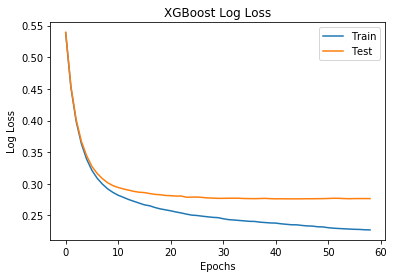

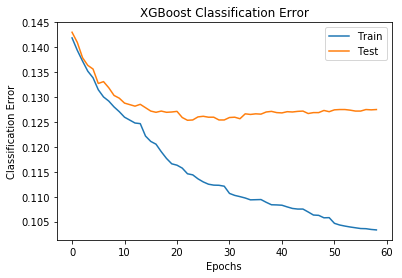

In [34]:
#plot
# retrieve performance metrics

epochs = len(eval_result['train']['error'])
x = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x, eval_result['train']['logloss'], label='Train')
ax.plot(x, eval_result['eval']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('Epochs')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x, eval_result['train']['error'], label='Train')
ax.plot(x, eval_result['eval']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.xlabel('Epochs')
plt.title('XGBoost Classification Error')
plt.show()

### Important Features

In [35]:
features_contribution = pd.Series(xgb_m.get_fscore()).sort_values(ascending=False)

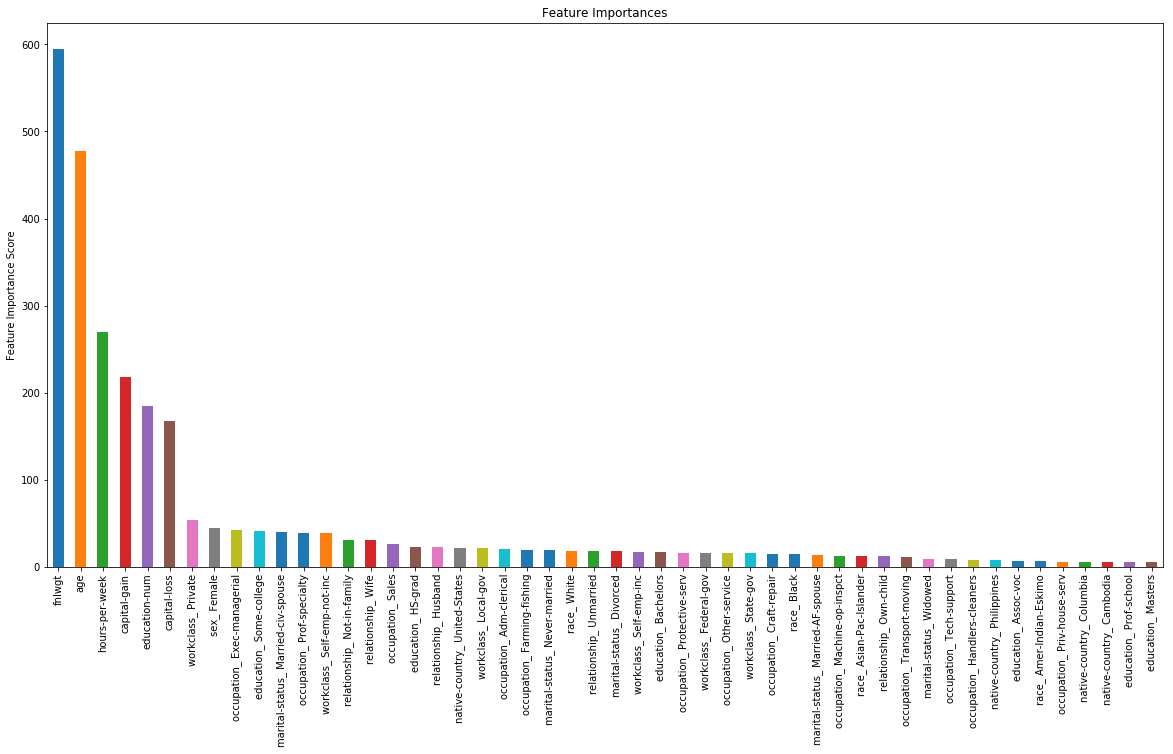

In [36]:
plt.figure(figsize=(20,10))
features_contribution[:50].plot(kind='bar', title='Feature Importances')
#features_contribution[:50].plot(kind='line')
plt.ylabel('Feature Importance Score')
plt.show()

In [37]:
ypred = xgb_m.predict(dtest)

In [56]:
print(ypred)   # we can classify label by having thereshold .50
#masking in 0 and 1
y_xgb=np.where(ypred > 0.5, 1, 0)    # or simply can mask like   (ypred > .5).astype(int)
print('Predictions', y_xgb)



[0.00291953 0.13501593 0.39508814 ... 0.79625547 0.02460182 0.79995364]
Predictions [0 0 0 ... 1 0 1]


**Observations:** 
    --We can provide differnet parameters to above models
    -- can select features repetitively to have better performance